# Hans 2024 data

Should probably formalize this as a Luigi or Airflow pipeline, but for now let's get everything set up interactively in notebooks so we can plot along the way.

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import configuration as config

/mnt/arkk/llm_detector/classifier


Load and combine the scored text fragment data from the Hans 2024 corpus.

In [2]:
datasets = {
    'cc_news': 'cc_news-scores.json',
    'pubmed': 'pubmed-scores.json',
    'cnn': 'cnn-scores.json'
}

dataframes = []

for dataset, filename in datasets.items():

    print(f'\nLoading {dataset}:')

    dataframe = pd.read_json(f'{config.HANS_DATA_PATH}/{filename}')

    # Replace and remove string 'OOM' and 'NAN' values
    dataframe.replace('NAN', np.nan, inplace = True)
    dataframe.replace('OOM', np.nan, inplace = True)
    dataframe.dropna(inplace = True)

    # Update name of score column, some earlier runs called
    # it by the old names
    dataframe.rename(columns = {
        'Binoculars score': 'Perplexity ratio score',
        'Observer peak memory (GB)': 'Reader peak memory (GB)',
        'Performer peak memory (GB)': 'Writer peak memory (GB)'
    }, inplace = True)

    dataframe.info()

    # Fix some d-types
    dataframe = dataframe.astype({
        'Fragment': int,
        'Fragment length (tokens)': int,
        'Reader peak memory (GB)': float,
        'Writer peak memory (GB)': float,
        'Perplexity': float,
        'Cross-perplexity': float,
        'Perplexity ratio score': float
    })

    # get rid of some unnecessary columns
    dataframe.drop([
        'Fragment', 
        'Reader peak memory (GB)', 
        'Writer peak memory (GB)'
    ], axis = 1, inplace = True)

    dataframes.append(dataframe)

# Combine the individual datasets and reset the index
data_df = pd.concat(dataframes, axis = 0)
data_df.reset_index(inplace = True, drop = True)

print('\nCombined dataset:')
data_df.info()


Loading cc_news:
<class 'pandas.core.frame.DataFrame'>
Index: 40752 entries, 0 to 42140
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fragment                  40752 non-null  int64  
 1   Fragment length (tokens)  40752 non-null  object 
 2   Dataset                   40752 non-null  object 
 3   Source                    40752 non-null  object 
 4   String                    40752 non-null  object 
 5   Reader peak memory (GB)   40752 non-null  float64
 6   Writer peak memory (GB)   40752 non-null  float64
 7   Perplexity                40752 non-null  object 
 8   Cross-perplexity          40752 non-null  object 
 9   Perplexity ratio score    40752 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 3.4+ MB

Loading pubmed:
<class 'pandas.core.frame.DataFrame'>
Index: 51521 entries, 0 to 52920
Data columns (total 10 columns):
 #   Column                    Non-

Take a quick look for sanity...

In [3]:
# Get human and synthetic fragments
human_fragments = data_df[data_df['Source'] == 'human']
synthetic_fragments = data_df[data_df['Source'] == 'synthetic']

# Get the size of each
human_fragment_count = len(human_fragments)
synthetic_fragment_count = len(synthetic_fragments)

# And the percent synthetic
percent_synthetic = round((synthetic_fragment_count / (synthetic_fragment_count + human_fragment_count)) * 100, 1)

print(f'Have {human_fragment_count} human text fragments and {synthetic_fragment_count} synthetic fragments.')
print(f'Dataset is {percent_synthetic}% synthetic fragments.')

Have 88592 human text fragments and 32420 synthetic fragments.
Dataset is 26.8% synthetic fragments.


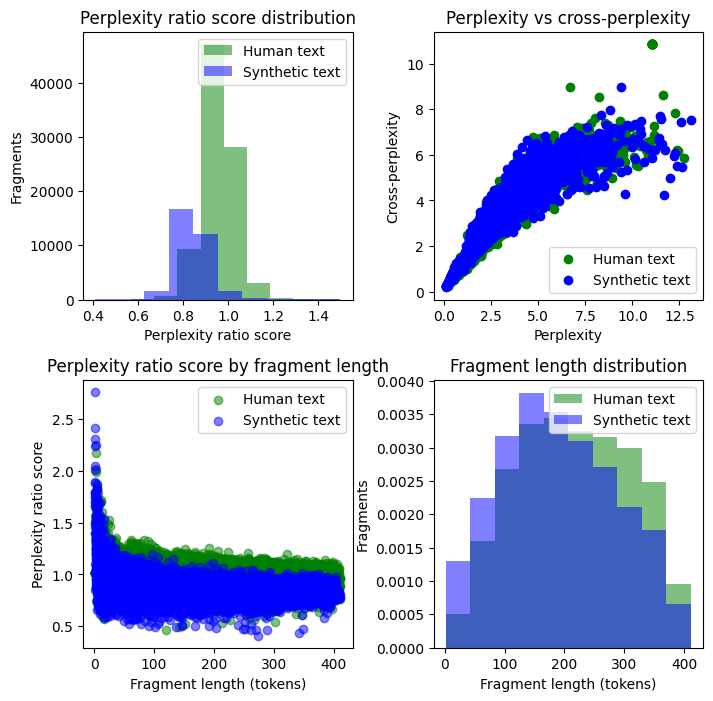

In [4]:
# Set up a 2 x 2 figure for some diagnostic plots
fig, axs = plt.subplots(
    2,
    2,
    figsize = (8, 8),
    gridspec_kw = {'wspace':0.3, 'hspace':0.3}
)

# Plot distribution of perplexity ratio scores
axs[0,0].set_title('Perplexity ratio score distribution')
axs[0,0].hist(human_fragments['Perplexity ratio score'][human_fragments['Perplexity ratio score'] < 1.5], facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[0,0].hist(synthetic_fragments['Perplexity ratio score'][synthetic_fragments['Perplexity ratio score'] < 1.5], facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[0,0].legend(loc = 'upper right')
axs[0,0].set_xlabel('Perplexity ratio score')
axs[0,0].set_ylabel('Fragments')

# Scatterplot of perplexity vs cross-perplexity
axs[0,1].set_title('Perplexity vs cross-perplexity')
axs[0,1].scatter(human_fragments['Perplexity'], human_fragments['Cross-perplexity'], c = 'green', label = 'Human text')
axs[0,1].scatter(synthetic_fragments['Perplexity'], synthetic_fragments['Cross-perplexity'], c = 'blue', label = 'Synthetic text')
axs[0,1].legend(loc = 'lower right')
axs[0,1].set_xlabel('Perplexity')
axs[0,1].set_ylabel('Cross-perplexity')

# Scatter plot of perplexity ratio score as a function of the
# the text fragment length
axs[1,0].set_title('Perplexity ratio score by fragment length')
axs[1,0].scatter(human_fragments['Fragment length (tokens)'], human_fragments['Perplexity ratio score'], c = 'green', alpha = 0.5, label = 'Human text')
axs[1,0].scatter(synthetic_fragments['Fragment length (tokens)'], synthetic_fragments['Perplexity ratio score'], c = 'blue', alpha = 0.5, label = 'Synthetic text')
axs[1,0].legend(loc = 'upper right')
axs[1,0].set_xlabel('Fragment length (tokens)')
axs[1,0].set_ylabel('Perplexity ratio score')

# Plot length distributions for human and synthetic text fragments
axs[1,1].set_title('Fragment length distribution')
axs[1,1].hist(human_fragments['Fragment length (tokens)'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[1,1].hist(synthetic_fragments['Fragment length (tokens)'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[1,1].legend(loc = 'upper right')
axs[1,1].set_xlabel('Fragment length (tokens)')
axs[1,1].set_ylabel('Fragments')

plt.show()

OK, looks good so far, save the combined data as JSON for later use.

In [5]:
# Save as JSON for later use
output_file = config.COMBINED_SCORED_HANS_DATA

with open(output_file, 'w') as file:
    file.write(data_df.to_json())

Next, let's split the data in to training and testing subsets. This way as we do the feature engineering steps we are not leaking data.

In [6]:
training_df = data_df.sample(frac = 0.8, random_state = 42)
testing_df = data_df.drop(training_df.index)

training_df.reset_index(inplace = True, drop = True)
testing_df.reset_index(inplace = True, drop = True)

print(f'Have {len(training_df)} training examples')
print(f'Have {len(testing_df)} testing examples')
print()
testing_df.info()

Have 96810 training examples
Have 24202 testing examples

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24202 entries, 0 to 24201
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fragment length (tokens)  24202 non-null  int64  
 1   Dataset                   24202 non-null  object 
 2   Source                    24202 non-null  object 
 3   String                    24202 non-null  object 
 4   Perplexity                24202 non-null  float64
 5   Cross-perplexity          24202 non-null  float64
 6   Perplexity ratio score    24202 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 1.3+ MB


And finaly, save the split data for future use.

In [7]:
# Save testing data
output_file = config.COMBINED_SCORED_HANS_TRAINING_DATA

with open(output_file, 'w') as file:
    file.write(training_df.to_json())

# Save testing data
output_file = config.COMBINED_SCORED_HANS_TESTING_DATA

with open(output_file, 'w') as file:
    file.write(testing_df.to_json())